# Quantum State Preparation Method Call Demo

This notebook will give a simple walk-through of using the pre-implemented quantum state preparation (QSP) function `qsp_qubit_eff` to execute the following QSP operation:
$$U_{\mathrm{QSP}} |0^n\rangle = |\psi\rangle = \frac{1}{\lVert \mathbf{x}\rVert}\sum_{i=0}^{2^{n-1}}x_i |i\rangle, x_i \in \mathbb{C}$$

In other words, we can prepare an arbitrary $n$-qubit quantum state (with complex amplitudes) from an $n$-qubit product state. See https://github.com/guikaiwen/qubit_efficient_QSP/blob/main/%5BDetailed%20Implementation%5D%20QSP.ipynb for a detail implementation walk-through.

In [1]:
# Import Braket libraries
import braket
from braket.circuits import Circuit
from braket.aws import AwsDevice
from braket.devices import LocalSimulator

# Import the QSP function and some helper functions
from qsp_circ_construction_qubit_efficient import qsp_qubit_eff
from helper_functions import *

## A Simple Example

We will prepare the state $|\psi\rangle = \sqrt{0.03}|000\rangle + \sqrt{0.07}|001\rangle + \sqrt{0.15}|010\rangle + \sqrt{0.05}|011\rangle + \sqrt{0.1}|100\rangle + \sqrt{0.3}|101\rangle + \sqrt{0.2}|110\rangle + \sqrt{0.1}|111\rangle$

__Input:__ a python array $[\sqrt{0.03}, \sqrt{0.07}, \sqrt{0.15}, \sqrt{0.05}, \sqrt{0.1}, \sqrt{0.3}, \sqrt{0.2}, \sqrt{0.1}]$

In [2]:
my_amplitude_vec = [np.sqrt(0.03), np.sqrt(0.07), np.sqrt(0.15), np.sqrt(0.05), np.sqrt(0.1), np.sqrt(0.3), np.sqrt(0.2), np.sqrt(0.1)]
print(row_to_column_vector(round_to_three_significant_digits(my_amplitude_vec, 3)))

[[0.173]
 [0.265]
 [0.387]
 [0.224]
 [0.316]
 [0.548]
 [0.447]
 [0.316]]


__output:__ the correponding quantum circuit that creates this state from the $|000\rangle$ state

In [3]:
initialized_circ = qsp_qubit_eff(my_amplitude_vec)
print(initialized_circ)

T  : |   0    |   1    |2|   3    |4|   5    |6|   7    |8|   9    |10|11|   12   |13|
                                                                                      
q0 : -Ry(1.98)-C--------X-C--------X-C----------C--------X-C--------X--X--C--------X--
               |          |          |          |          |              |           
q1 : ----------Ry(1.43)---Ry(1.91)---C--------X-C--------X-C--------X-----C--------X--
                                     |          |          |              |           
q2 : --------------------------------Ry(1.23)---Ry(2.09)---Ry(1.05)-------Ry(1.98)----

T  : |   0    |   1    |2|   3    |4|   5    |6|   7    |8|   9    |10|11|   12   |13|


### Verify on the Simulator

Now let's test our constructed circuit on the Braket local simulator!

In [4]:
braket_device = LocalSimulator() # define the simulator
initialized_circ.state_vector() # convert the circuit to state vector
braket_state_vector_result = braket_device.run(initialized_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_state_vector_result, 3))) # print out the resulted state vector

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.173+0.j]
 [0.265+0.j]
 [0.387+0.j]
 [0.224+0.j]
 [0.316+0.j]
 [0.548+0.j]
 [0.447+0.j]
 [0.316+0.j]]


Let's see the actual difference between the expected amplitude vector vs what is actually produced

In [5]:
print(row_to_column_vector(np.array(braket_state_vector_result) - np.array(my_amplitude_vec)))

[[-2.77555756e-17+0.j]
 [-5.55111512e-17+0.j]
 [ 0.00000000e+00+0.j]
 [-2.77555756e-17+0.j]
 [-5.55111512e-17+0.j]
 [ 1.11022302e-16+0.j]
 [ 0.00000000e+00+0.j]
 [ 5.55111512e-17+0.j]]


The result matches perfectly with the desired output!

-----------------------------------

## [Advanced] Generate Complex Arbitrary Quantum State

Now let's generate a size $2^3 = 8$ random array with complex values:

In [6]:
# Import some basic python package
import math
import numpy as np
import random

In [7]:
np.random.seed(10) # fix a seed for data reproduction purpose, you can change this value to play with other results
n = 3 # number of qubits. We can encode 2^n number of values with n qubits!
normalized_complex_array = generate_normalized_complex_array(n)
print(row_to_column_vector(round_to_three_significant_digits(normalized_complex_array, 3)))

[[ 0.222-0.271j]
 [-0.392-0.337j]
 [ 0.109+0.152j]
 [ 0.204+0.371j]
 [-0.001-0.406j]
 [-0.225+0.01j ]
 [-0.247+0.256j]
 [ 0.213+0.092j]]


We can construct the circuit using the same `qsp_qubit_eff` function. Notice that there is another layer of multi-control Rz gate added on top of the multi-control Ry gate to pump in the phase values.

In [8]:
initialized_circ = qsp_qubit_eff(normalized_complex_array)
print(initialized_circ)

T  : |   0    |   1    |   2    |   3    |4|   5    |   6    |7|   8    |    9    |10|   11   |   12   |13|   14   |   15   |16|17|   18   |   19    |20|
                                                                                                                                                         
q0 : -Ry(1.36)-Rz(1.39)-C--------C--------X-C--------C--------X-C--------C------------C--------C--------X--C--------C--------X--X--C--------C---------X--
                        |        |          |        |          |        |            |        |           |        |              |        |            
q1 : -------------------Ry(1.48)-Rz(0.61)---Ry(1.28)-Rz(2.67)---C--------C---------X--C--------C--------X--C--------C--------X-----C--------C---------X--
                                                                |        |            |        |           |        |              |        |            
q2 : -----------------------------------------------------------Ry(1.16)-Rz(

We execute the constructed circuit using the Braket's local simulator:

In [9]:
braket_device = LocalSimulator() # define the simulator
initialized_circ.state_vector() # convert the circuit to state vector
braket_state_vector_result = braket_device.run(initialized_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_state_vector_result, 3))) # print out the resulted state vector

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[ 0.109-0.333j]
 [-0.488-0.172j]
 [ 0.157+0.102j]
 [ 0.324+0.272j]
 [-0.148-0.378j]
 [-0.206+0.091j]
 [-0.137+0.328j]
 [ 0.232+0.008j]]


Notice that the circuit state vector output looks very different from the generated vector input. Why is this the case? This is because we have a global phase difference! In other words, instead of having the exact state $|\psi\rangle$, we instead have $e^{i\theta}|\psi\rangle$. This additional global phase does not carry any physical meanings, nor does it affect the final measurement results on the real quantum computer.

We can perform the test below to see if circuit state vector result is the same as the input vector but only with a global phase difference. For the circuit state vector result $|\psi'\rangle = e^{i\theta}|\psi\rangle$ and input vector $|\psi\rangle$, we should expect $|\langle\psi'|\psi\rangle| = 1$

In [10]:
print(np.abs(np.dot(normalized_complex_array, np.conj(braket_state_vector_result))))

1.0000000000000002


We can also try to compute the phase difference $\theta_i$ between each pair of basis:

In [11]:
phase_v1_arr = np.angle(normalized_complex_array)
phase_v2_arr = np.angle(braket_state_vector_result)

# Compute the global phase difference between v1 and v2
global_phase_diff_arr = phase_v1_arr - phase_v2_arr
global_phase_diff_arr = (global_phase_diff_arr + np.pi) % (2 * np.pi) - np.pi
print(global_phase_diff_arr)

[0.37114178 0.37114178 0.37114178 0.37114178 0.37114178 0.37114178
 0.37114178 0.37114178]


You can see that all the phase differences are the same across all values (and thus a global phase)!

Now we can add the phase correction to the circuit state vector output:

In [12]:
global_phase_corrected_braket_state_vector_result = braket_state_vector_result * np.exp(1j * global_phase_diff_arr[0])
print(row_to_column_vector(round_to_three_significant_digits(global_phase_corrected_braket_state_vector_result, 3)))

[[ 0.222-0.271j]
 [-0.392-0.337j]
 [ 0.109+0.152j]
 [ 0.204+0.371j]
 [-0.001-0.406j]
 [-0.225+0.01j ]
 [-0.247+0.256j]
 [ 0.213+0.092j]]


This is now the same as the input vector.

Printing out the actual differences:

In [13]:
print(row_to_column_vector(global_phase_corrected_braket_state_vector_result - normalized_complex_array))

[[-2.77555756e-17-5.55111512e-17j]
 [ 1.11022302e-16+0.00000000e+00j]
 [ 6.93889390e-17+1.11022302e-16j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.75133952e-17-1.66533454e-16j]
 [-8.32667268e-17+2.42861287e-17j]
 [-5.55111512e-17-5.55111512e-17j]
 [ 0.00000000e+00+1.38777878e-17j]]


## [Optional] Generate Sparse Arbitrary Quantum State

Now, let's create a a w-like state: $|\psi\rangle = \alpha|001\rangle + \beta|010\rangle + \gamma|100\rangle$ and see what happens.

We first create a 1d array of size $2^3 = 8$ with arbitrary $\alpha$, $\beta$, and $\gamma$ values at their proper postion, and fill the rest postions with $0$s:

In [14]:
random.seed(10)
w_like_state = generate_normalized_real_sparse_array(3, [1, 2, 4]) # |001> is at location 1, |010> is at location 2, |100> is at location 4
print(row_to_column_vector(round_to_three_significant_digits(w_like_state, 3)))

[[0.   ]
 [0.622]
 [0.467]
 [0.   ]
 [0.629]
 [0.   ]
 [0.   ]
 [0.   ]]


Now, call the same `qsp_qubit_eff` function to generate the circuit:

In [15]:
initialized_circ = qsp_qubit_eff(w_like_state)
print(initialized_circ)

T  : |   0    |1|   2    |3|4|   5    |6|
                                         
q0 : -Ry(1.36)-X-C--------X-X-C--------X-
                 |            |          
q1 : ------------Ry(1.29)-X---C--------X-
                              |          
q2 : -------------------------Ry(3.14)---

T  : |   0    |1|   2    |3|4|   5    |6|


We can see that we only need $3$ multi-control Ry gates instead of $7$.

Now, execute the circuit on the Braket simulator:

In [16]:
initialized_circ.state_vector() # convert the circuit to state vector
braket_state_vector_result = braket_device.run(initialized_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_state_vector_result, 3))) # print out the resulted state vector

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.   +0.j]
 [0.622+0.j]
 [0.467+0.j]
 [0.   +0.j]
 [0.629+0.j]
 [0.   +0.j]
 [0.   +0.j]
 [0.   +0.j]]


The result matches the desired output.

## [Optional] Generate Sparse Arbitrary Quantum State

Let's also see how the Qiskit's implementation look like.

In [17]:
# Import Qiskit libraries
from qiskit import QuantumCircuit
from qiskit.execute_function import execute
from qiskit import BasicAer
from qiskit import transpile
qiskit_backend = BasicAer.get_backend('statevector_simulator')

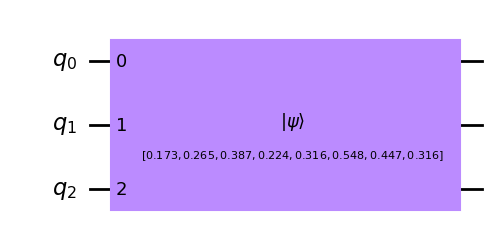

In [18]:
qc = QuantumCircuit(n)
qc.initialize(my_amplitude_vec, range(n))
qc.draw(output='mpl')

This looks confusing, but we can decompose the 'big thing' into standard quantum gates.

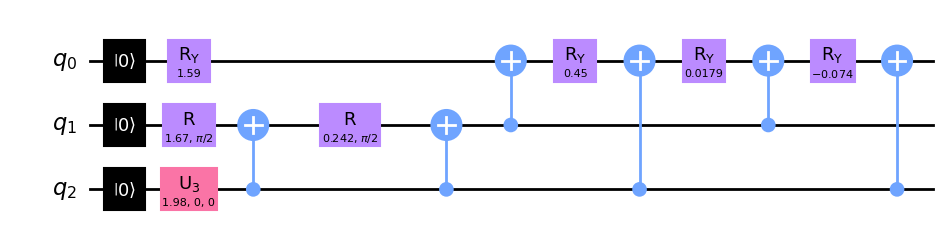

In [19]:
qc.decompose().decompose().decompose().decompose().decompose().decompose().draw(output='mpl')

You can see that rather than using multi-control rotation gates, Qiskit uses many CNOT gates, which are typically less efficient when using the simulator.

In [20]:
# Transpile for simulator
simulator = BasicAer.get_backend('statevector_simulator')
qc = transpile(qc, simulator)

job = execute(qc, qiskit_backend)
qiskit_state_vector_result = job.result().get_statevector()
print(row_to_column_vector(round_to_three_significant_digits(qiskit_state_vector_result, 3))) # print out the resulted state vector

[[0.173+0.j]
 [0.265+0.j]
 [0.387+0.j]
 [0.224+0.j]
 [0.316+0.j]
 [0.548+0.j]
 [0.447+0.j]
 [0.316+0.j]]


In [21]:
print(row_to_column_vector(qiskit_state_vector_result - my_amplitude_vec))

[[ 0.00000000e+00+0.j]
 [ 5.55111512e-17+0.j]
 [ 0.00000000e+00+0.j]
 [ 2.77555756e-17+0.j]
 [ 0.00000000e+00+0.j]
 [-3.33066907e-16+0.j]
 [-5.55111512e-17+0.j]
 [-1.11022302e-16+0.j]]


In [22]:
import braket._sdk as braket_sdk
braket_sdk.__version__

'1.55.0'

In [23]:
import sys
print(sys.version)

3.10.11 (main, May 17 2023, 14:30:36) [Clang 14.0.6 ]
